# QuTiPv5 Paper Example: The Quantum Optimal Control Package

Authors: Maximilian Meyer-Mölleringhof (m.meyermoelleringhof@gmail.com), Boxi Li (etamin1201@gmail.com), Neill Lambert (nwlambert@gmail.com)

Quantum systems are naturally sensitive to their environment and external perturbations.
This is great, as it allows for very precise measurements.
However, it also makes handling errors and imprecisions a big challenge.
In the case for quantum computing, finding the optimal parameters to achieve a desired operation is this thus an important problem.
Optimization parameters may include amplitude, frequency, duration, bandwidth, etc. and are generally directly dependent on the considered hardware.

To find these optimal control parameters, several methods have been developed.
Here, we look at three algorithms: *gradient ascent pulse engineering* (GRAPE) [\[3\]](#References), *chopped random basis* (CRAB) [\[4\]](#References) and *gradient optimization af analytic controls* (GOAT) [\[5\]](#References).
Whereas the former two have been part of the `QuTiP-QTRL` package of QuTiPv4, the latter is a new addition in version 5.
Althogether, these algorithms are now included in the new `QuTiP-QOC` package that also adds `QuTiP-JAX` [\[6\]](#References) integration via the JAX optimization technique (JOPT).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from jax import jit, numpy
from qutip import (about, gates, liouvillian, qeye, sigmam, sigmax, sigmay,
                   sigmaz)
from qutip_qoc import Objective, optimize_pulses

%matplotlib inline

## Introduction

In this example we want to implement a Hadamard gate on a single qubit.
In general, a qubit might be subject to decoherence which can be captured using the Lindblad formalism with the jump operator $\sigma_{-}$.

For simplicity, we consider a control Hamiltonian parametrized by $\sigma_x$, $\sigma_y$ and $\sigma_z$:

$H_c(t) = c_x(t) \sigma_x + c_y(t) \sigma_y + c_z(t) \sigma_z$

with $c_x(t)$, $c_y(t)$ and $c_z(t)$ as independent control parameters.
Additionally, we model a constant drift Hamiltonian

$H_d = \dfrac{1}{2} (\omega \sigma_z + \delta \sigma_x)$,

with associated energy splitting $\omega$ and tunneling rate $\delta$.
The amplitude damping rate for the collapse operator $C = \sqrt{\gamma} \sigma_-$ is denoted as $\gamma$.

In [2]:
# energy splitting, tunneling, amplitude damping
omega = 0.1  # energy splitting
delta = 1.0  # tunneling
gamma = 0.1  # amplitude damping
sx, sy, sz = sigmax(), sigmay(), sigmaz()

Hc = [sx, sy, sz]  # control operator
Hc = [liouvillian(H) for H in Hc]

Hd = 1 / 2 * (omega * sz + delta * sx)  # drift term
Hd = liouvillian(H=Hd, c_ops=[np.sqrt(gamma) * sigmam()])

# combined operator list
H = [Hd, Hc[0], Hc[1], Hc[2]]

In [3]:
# objectives for optimization
initial = qeye(2)
target = gates.hadamard_transform()
fid_err = 0.01

In [4]:
# pulse time interval
times = np.linspace(0, np.pi / 2, 100)

## Implementation

### GRAPE Algorithm

The GRAPE algorithm works by minimizing an infidelity loss function that measures how close the final state or unitary tranformation is to the desired target.
Starting from the provided `guess` control pulse, it optimizes evenly spaced piecewise constant pulse amplitudes.
In the end, it strives to achieve the desired target infidelity, sepcified by the `fid_err_targ` keyword.

In [5]:
res_grape = optimize_pulses(
    objectives=Objective(initial, H, target),
    control_parameters={
        "ctrl_x": {"guess": np.sin(times), "bounds": [-1, 1]},
        "ctrl_y": {"guess": np.cos(times), "bounds": [-1, 1]},
        "ctrl_z": {"guess": np.tanh(times), "bounds": [-1, 1]},
    },
    tlist=times,
    algorithm_kwargs={"alg": "GRAPE", "fid_err_targ": fid_err},
)

### CRAB Algorithm

This algorithm is based on the idea of expanding the control fields in a random basis and optimizing the expansion coefficients $\vec{\alpha}$.
This has the advantage of using analytical control functions $c(\vec{\alpha}, t)$ on a continuous time interval, and is by default a Fourier expansion.
This reduces the search space to the function parameters.
Typically, these parameters can efficiently be calculated through direct search algorithms (like Nelder-Mead).
The basis function is only expanded for some finite number of summands and the initial basis coefficients are usually picked at random.

In [6]:
n_params = 3  # adjust in steps of 3
alg_args = {"alg": "CRAB", "fid_err_targ": fid_err, "fix_frequency": False}

In [7]:
res_crab = optimize_pulses(
    objectives=Objective(initial, H, target),
    control_parameters={
        "ctrl_x": {
            "guess": [1 for _ in range(n_params)],
            "bounds": [(-1, 1)] * n_params,
        },
        "ctrl_y": {
            "guess": [1 for _ in range(n_params)],
            "bounds": [(-1, 1)] * n_params,
        },
        "ctrl_z": {
            "guess": [1 for _ in range(n_params)],
            "bounds": [(-1, 1)] * n_params,
        },
    },
    tlist=times,
    algorithm_kwargs=alg_args,
)

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/scipy/optimize/_basinhopping.py:298: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  return self.minimizer(self.func, x0, **self.kwargs)
/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/scipy/optimize/_basinhopping.py:298: OptimizeWarning: Unknown solver options: gtol
  return self.minimizer(self.func, x0, **self.kwargs)


### GOAT Algorithm

Similar to CRAB, this method also works with analytical control functions.
By constructing a coupled system of equations of motion, the derivative of the (time ordered) evolution operator with respect to the control parameters can be calculated after numerical forward integration.
In unconstrained settings, GOAT was found to outperform the previous described methods in terms of convergence and fidelity achievement.
The QuTiP implementation allows for arbitrary control functions provided together with their respective derivatives in a common python manner.

In [8]:
def sin(t, c):
    return c[0] * np.sin(c[1] * t)


# derivatives
def grad_sin(t, c, idx):
    if idx == 0:  # w.r.t. c0
        return np.sin(c[1] * t)
    if idx == 1:  # w.r.t. c1
        return c[0] * np.cos(c[1] * t) * t
    if idx == 2:  # w.r.t. time
        return c[0] * np.cos(c[1] * t) * c[1]

In [9]:
H = [Hd] + [[hc, sin, {"grad": grad_sin}] for hc in Hc]

bnds = [(-1, 1), (0, 2 * np.pi)]
ctrl_param = {id: {"guess": [1, 0], "bounds": bnds} for id in ["x", "y", "z"]}

For even faster convergence QuTiP extends to original algorithm with the option to optimize controls with
respect to the overall time evolution, which can be enabled by specifying the additional time keyword
argument:

In [10]:
# treats time as optimization variable
ctrl_param["__time__"] = {
    "guess": times[len(times) // 2],
    "bounds": [times[0], times[-1]],
}

In [11]:
# run the optimization
res_goat = optimize_pulses(
    objectives=Objective(initial, H, target),
    control_parameters=ctrl_param,
    tlist=times,
    algorithm_kwargs={
        "alg": "GOAT",
        "fid_err_targ": fid_err,
    },
)

### JOT Algorithm - JAX integration

QuTiP's new JAX backend provides automatic differentiation capabilities that can be directly be used with the new control framework.
As with QuTiP’s GOAT implementation, any analytically defined control function can be handed to the algorithm.
However, in this method, JAX automatic differentiation abilities take care of calculating the derivative throughout the whole system evolution.
Therefore we don't have to provide any derivatives manually.
Compared to the previous example, this simply means to swap the control functions with their just-in-time compiled version.

In [12]:
@jit
def sin_y(t, d, **kwargs):
    return d[0] * numpy.sin(d[1] * t)


@jit
def sin_z(t, e, **kwargs):
    return e[0] * numpy.sin(e[1] * t)


@jit
def sin_x(t, c, **kwargs):
    return c[0] * numpy.sin(c[1] * t)

In [13]:
H = [Hd] + [[Hc[0], sin_x], [Hc[1], sin_y], [Hc[2], sin_z]]

In [14]:
res_jopt = optimize_pulses(
    objectives=Objective(initial, H, target),
    control_parameters=ctrl_param,
    tlist=times,
    algorithm_kwargs={
        "alg": "JOPT",
        "fid_err_targ": fid_err,
    },
)

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/equinox/_jit.py:55: UserWarning: Complex dtype support in Diffrax is a work in progress and may not yet produce correct results. Consider splitting your computation into real and imaginary parts instead.
  out = fun(*args, **kwargs)


## Comparison of Results

After running the global and local optimization, one can compare the results obtained by the various
algorithms through a `qoc.Result` object, which provides common optimization metrics along with the `optimized_controls`.

### Pulse Amplitudes

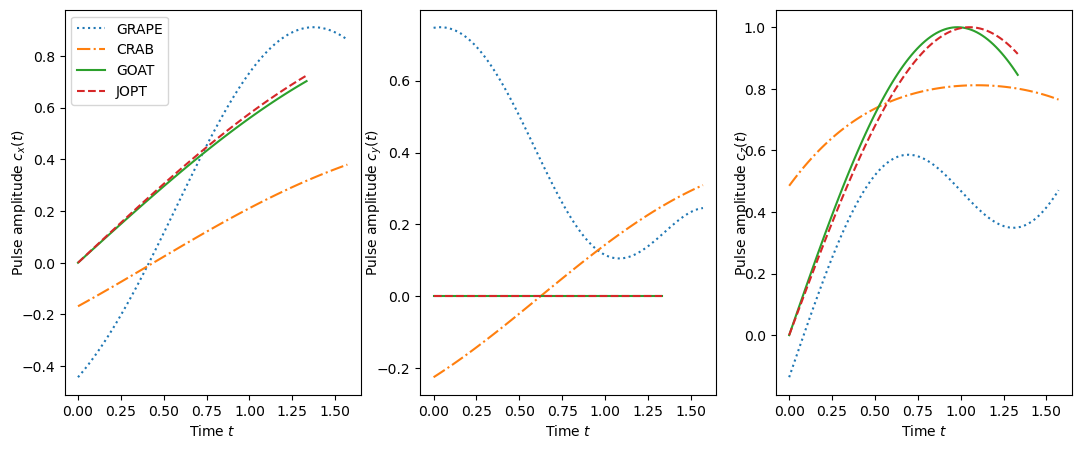

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(13, 5))

goat_range = times < res_goat.optimized_params[-1]
jopt_range = times < res_jopt.optimized_params[-1]

for i in range(3):
    ax[i].plot(times, res_grape.optimized_controls[i], ":", label="GRAPE")
    ax[i].plot(times, res_crab.optimized_controls[i], "-.", label="CRAB")
    ax[i].plot(
        times[goat_range],
        np.array(res_goat.optimized_controls[i])[goat_range],
        "-",
        label="GOAT",
    )
    ax[i].plot(
        times[jopt_range],
        np.array(res_jopt.optimized_controls[i])[jopt_range],
        "--",
        label="JOPT",
    )

    ax[i].set_xlabel(r"Time $t$")

ax[0].legend(loc=0)
ax[0].set_ylabel(r"Pulse amplitude $c_x(t)$", labelpad=-5)
ax[1].set_ylabel(r"Pulse amplitude $c_y(t)$", labelpad=-5)
ax[2].set_ylabel(r"Pulse amplitude $c_z(t)$", labelpad=-5)

plt.show()

### Infidelities and Processing Time

In [16]:
print("GRAPE: ", res_grape.fid_err)
print(res_grape.total_seconds, " seconds")
print()
print("CRAB : ", res_crab.fid_err)
print(res_crab.total_seconds, " seconds")
print()
print("GOAT : ", res_goat.fid_err)
print(res_goat.total_seconds, " seconds")
print()
print("JOPT : ", res_jopt.fid_err)
print(res_jopt.total_seconds, " seconds")

GRAPE:  0.005258318956042762
0.2993  seconds

CRAB :  0.008930309630280554
0.6364  seconds

GOAT :  0.006136590373869528
0.0408  seconds

JOPT :  0.008344510591995532
3.2061  seconds


## References

[1] [QuTiP 5: The Quantum Toolbox in Python](https://arxiv.org/abs/2412.04705)

[2] [QuTiP-QOC Repository](https://github.com/qutip/qutip-qoc)

[3] [Khaneja, et. al, Journal of Magnetic Resonance (2005)](https://www.sciencedirect.com/science/article/pii/S1090780704003696)

[4] [Caneva, et. al, Phys. Rev. A (2011)](https://link.aps.org/doi/10.1103/PhysRevA.84.022326)

[5] [Machnes, et. al, Phys. Rev. Lett. (2018)](https://link.aps.org/doi/10.1103/PhysRevLett.120.150401)

[6] [QuTiP-JAX Repository](https://github.com/qutip/qutip-jax)


## About

In [17]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

## Testing

In [18]:
assert (
    res_grape.fid_err < fid_err
), f"GRAPE did not reach the target infidelity of < {fid_err}."
assert (
    res_crab.fid_err < fid_err
), f"CRAB did not reach the target infidelity of < {fid_err}."
assert (
    res_goat.fid_err < fid_err
), f"GOAT did not reach the target infidelity of < {fid_err}."
assert (
    res_jopt.fid_err < fid_err
), f"JOPT did not reach the target infidelity of < {fid_err}."